In [3]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

from data_preprocessing_utils import data_for_training
from utils import compute_error
from models import get_mlp_model

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tabulate import tabulate

import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.neural_network import MLPRegressor

from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint

c:\Users\abdoulnasser\anaconda3\envs\stock\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load data

In [4]:
company_data=pd.read_csv('../data/transfertLearning/train.csv', index_col=0 )

company_data.head()


,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


Delete attributes if you have attributes to delete

In [ ]:
# company_data=company_data.drop(["attribut_1","attribut_2"], axis=1)

Data aggregation by month

In [5]:
# Convert date columns to datetime format
company_data['date'] = pd.to_datetime(company_data['date'])

# Create a new column for the year and month
company_data['Year'] = company_data['date'].dt.year
company_data['Month'] = company_data['date'].dt.month

# Group data by year and month and calculate the desired aggregates for each group
sales_month_aggregated=company_data.groupby(['Year', 'Month','store_nbr','family']).agg({
    'sales': 'sum',
    'onpromotion': 'first',
}).reset_index()

data = sales_month_aggregated.copy()

In [6]:
data['sales']=data[['sales']].round()
data.sales=data.sales.astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99792 entries, 0 to 99791
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Year         99792 non-null  int64 
 1   Month        99792 non-null  int64 
 2   store_nbr    99792 non-null  int64 
 3   family       99792 non-null  object
 4   sales        99792 non-null  int32 
 5   onpromotion  99792 non-null  int64 
dtypes: int32(1), int64(4), object(1)
memory usage: 4.2+ MB


Encoding categorial variables

In [ ]:
# Select the necessary columns for the model training
selected_features = ['Year', 'Month',"store_nbr",'family','onpromotion']
X = data[selected_features]
y = data['sales']

# # One-Hot Encoding for the categorical columns
X_encoded = pd.get_dummies(X, columns=['store_nbr','family'])

Divide the data into training, validation, and test sets

In [ ]:
# Divide the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_encoded, y, test_size=0.3, random_state=27)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=27)

Loading the Initial Model

In [ ]:
hidden_layer_one=50
hidden_layer_two=100
dropout_one=0
dropout_two=0

base_model=get_mlp_model(input_shape=(X_test.shape[1],),hidden_layer_one=hidden_layer_one,dropout_one=dropout_one,hidden_layer_two=hidden_layer_two,dropout_two=dropout_two)

checkpoint_filepath = '../checkpoint/base_model_checkpoint.h5'

# Load the best weights from the saved checkpoint
base_model.load_weights(checkpoint_filepath)

# Evaluate the performance of the model on the test set
y_test_pred = base_model.predict(X_test)

# Calculate performance metrics
rmse2, corr2, mae2, rae2, rrse2, mape2, r2_2 = compute_error(y_test.values, y_test_pred.reshape(y_test_pred.shape[0]))
print("RMSE:", rmse2)
print("Corrélation:", corr2)
print("MAE:", mae2)
print("RAE:", rae2)
print("RRSE:", rrse2)
print("MAPE:", mape2)
print("R2:", r2_2)
print("----------------------------------")

660/660 [==============================] - 4s 1ms/step
RMSE: 17.105777088138606
Corrélation: 0.9233587503248789
MAE: 7.524430285860021
RAE: 0.4062391161658368
RRSE: 0.38490070420095845
MAPE: 124.19359846897471
R2: 0.8518514479056063
----------------------------------


model design and training

In [ ]:
model=base_model

new_input_shape = (X_train.shape[1],) # Dimension of your data for the model to be adapted
new_model = Sequential()

new_model.add(BatchNormalization())

# Add a new input layer with the number of neurons corresponding to the new dimension

new_model.add(Dense(2000, activation='relu', input_shape=new_input_shape))
new_model.add(Dense(1000, ))

new_model.add(Dense(model.layers[0].input.shape[1], activation='relu'))

# Add the first layer of the pre-trained model (including the first layer) to the new model
new_model.add(model.layers[0])

# Add the rest of the pre-trained model (excluding the first layer) to the new model
for layer in model.layers[1:]:
    new_model.add(layer)

# You can also add additional layers if required

# Compile the new model
new_model.compile(loss='mean_squared_error', optimizer="Adam")


# Define the ModelCheckpoint callback
checkpoint_filepath = 'model_checkpoint_2.h5'
model_checkpoint = ModelCheckpoint(
filepath=checkpoint_filepath,
save_best_only=True,
monitor='val_loss',
mode='min',
verbose=0
)

# Train the model on the training data with validation data and checkpoint callback
history = new_model.fit(X_train, y_train, epochs=700, batch_size=256,
            verbose=2, validation_data=(X_val, y_val),
            callbacks=[model_checkpoint])

# Load the best weights from the saved checkpoint
new_model.load_weights(checkpoint_filepath)

# Evaluate the performance of the model on the test set
y_test_pred = new_model.predict(X_test)

# Calculate performance metrics
rmse2, corr2, mae2, rae2, rrse2, mape2, r2_2 = compute_error(y_test.values, y_test_pred.reshape(y_test_pred.shape[0]))

print("RMSE:", rmse2)
print("Corrélation:", corr2)
print("MAE:", mae2)
print("RAE:", rae2)
print("RRSE:", rrse2)
print("MAPE:", mape2)
print("R2:", r2_2)
print("----------------------------------")




Epoch 1/700
273/273 - 4s - loss: 1297312384.0000 - val_loss: 2316465408.0000 - 4s/epoch - 14ms/step
Epoch 2/700


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


273/273 - 1s - loss: 1147893888.0000 - val_loss: 1120705792.0000 - 1s/epoch - 5ms/step
Epoch 3/700
273/273 - 1s - loss: 1089594752.0000 - val_loss: 1070091200.0000 - 1s/epoch - 5ms/step
Epoch 4/700
273/273 - 2s - loss: 529194496.0000 - val_loss: 144298064.0000 - 2s/epoch - 6ms/step
Epoch 5/700
273/273 - 1s - loss: 116106704.0000 - val_loss: 83909824.0000 - 1s/epoch - 5ms/step
Epoch 6/700
273/273 - 1s - loss: 84659336.0000 - val_loss: 72518928.0000 - 1s/epoch - 5ms/step
Epoch 7/700
273/273 - 1s - loss: 77535792.0000 - val_loss: 84659688.0000 - 1s/epoch - 5ms/step
Epoch 8/700
273/273 - 1s - loss: 74585904.0000 - val_loss: 68983512.0000 - 1s/epoch - 5ms/step
Epoch 9/700
273/273 - 1s - loss: 66691288.0000 - val_loss: 64487276.0000 - 1s/epoch - 5ms/step
Epoch 10/700
273/273 - 1s - loss: 63959900.0000 - val_loss: 66703640.0000 - 1s/epoch - 5ms/step
Epoch 11/700
273/273 - 1s - loss: 58690764.0000 - val_loss: 63655516.0000 - 1s/epoch - 5ms/step
Epoch 12/700
273/273 - 1s - loss: 59416832.0000 -

<ipython-input-28-40699a242ef7>:27: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - trues) / trues)) * 100


Save the weights of the best model for later loading

In [ ]:
new_model.save_weights('../checkpoint/transfert_learning_model_checkpoint.h5')

Comparison of Actual vs. Predicted Values

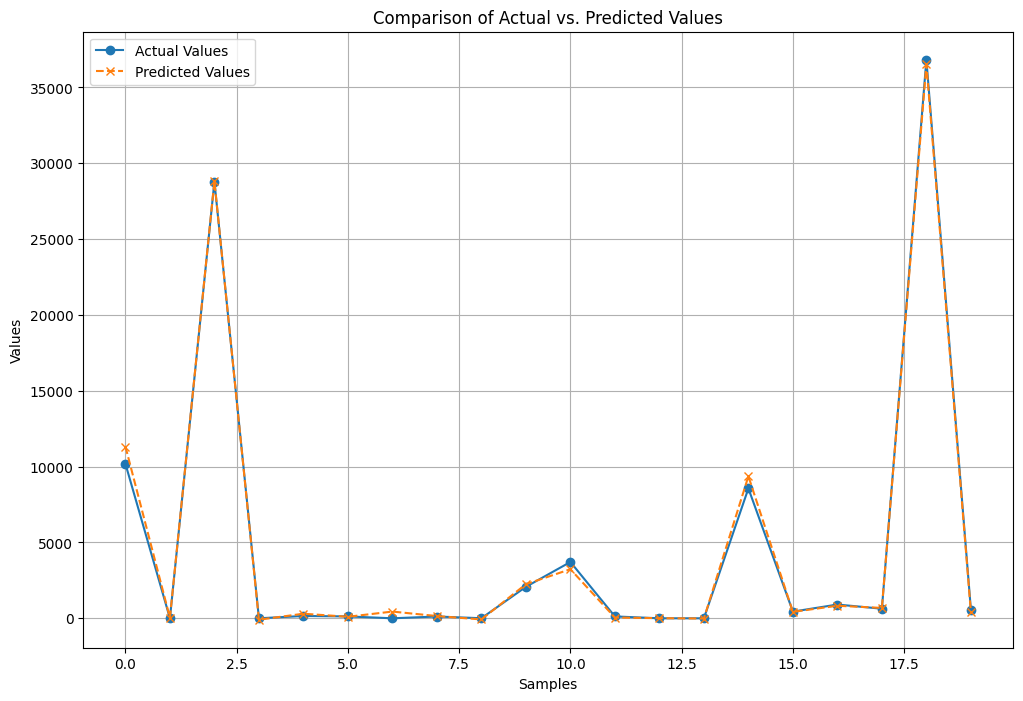

In [ ]:
import matplotlib.pyplot as plt


y_test_pred_int = y_test_pred.reshape(y_test_pred.shape[0])[-20:].astype(int)

# Create the chart
plt.figure(figsize=(12, 8))  # Définir la taille du graphique

# Plot actual and predicted values
plt.plot(range(len(y_test[-20:])), y_test[-20:], label='Actual Values', marker='o', linestyle='-')
plt.plot(range(len(y_test_pred_int)), y_test_pred_int, label='Predicted Values', marker='x', linestyle='--')

# Add title
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Comparison of Actual vs. Predicted Values')

# plot legend
plt.legend()

# Activate the grid
plt.grid(True)

# Save image in high resolution (300 DPI)
plt.savefig('comparison_plot.png', dpi=300)

# plot graph
plt.show()
